# Requirements
    python == 3.10.5
    pandas == 1.4.4
    numpy == 1.23.3
    scipy == 1.9.1
    scikit-learn == 1.1.2
    matplotlib == 3.5.3

# Import Libraries

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from scipy.stats import loguniform, randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

# Prepare Dataset
    1. Load original dataset
    2. Set column names
    3. Cleaning dataset (descibed in LAB#1)
    4. Split into predictor / target

In [21]:
# Load dataset
pd.options.mode.chained_assignment = None # ignore error on inplace
df = pd.read_csv('./dataset/breast-cancer-wisconsin.data')

# Set column name
attributes = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size',
              'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size',
              'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']

df.set_axis(attributes, axis = 'columns', inplace = True)

In [22]:
# Delete missing values
df = df[~df['Bare Nuclei'].isin(['?'])]

# Delete duplicated rows
df.drop_duplicates(keep = 'first', inplace = True)

# Delete unnecessary attribute
df.drop('Sample code number', axis = 'columns', inplace = True)

In [23]:
# Split dataset into predictor/target
predictor = df.iloc[:, :-1]
target = df['Class']

# Define Search Space
    1. Various scalers
    2. Various models
    3. Various model parameters

In [24]:
# Common
RANDOM_STATE = 19970602
scalers = [None, StandardScaler(), RobustScaler(), MinMaxScaler(), MaxAbsScaler()]

In [25]:
# By model
search_space = [
    {
        'preprocessing' : scalers,
        'classifier' : [DecisionTreeClassifier(),
                        DecisionTreeClassifier(criterion = 'entropy')],
        'classifier__splitter' : ['best', 'random'],
        'classifier__max_depth' : randint(1, 5),
        'classifier__min_samples_split' : randint(2, 4),
        'classifier__min_samples_leaf' : randint(1, 5),
        'classifier__max_features' : [None, 'sqrt', 'log2'],
        'classifier__random_state' : [RANDOM_STATE]
    },
    {
        'preprocessing' : scalers,
        'classifier' : [LogisticRegression()],
        'classifier__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
        'classifier__dual' : [False, True],
        'classifier__tol' : loguniform(1e-6, 1e-2),
        'classifier__C' : loguniform(1e-5, 1000.0),
        'classifier__fit_intercept' : [False, True],
        'classifier__intercept_scaling' : np.arange(0.1, 2.0, 0.1),
        'classifier__class_weight' : ['balanced', None],
        'classifier__random_state' : [RANDOM_STATE],
        'classifier__solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
        'classifier__max_iter' : np.arange(100, 600, 50)
    },
    {
        'preprocessing' : scalers,
        'classifier' : [SVC(cache_size = 1990)],
        'classifier__C' : loguniform(1e-5, 1000.0),
        'classifier__kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__degree' : randint(1, 10),
        'classifier__gamma' : ['scale', 'auto', *np.logspace(-1e-4, 1.5, 10)],
        'classifier__coef0' : np.arange(0.0, 1.0, 0.1),
        'classifier__shrinking' : [False, True],
        'classifier__tol' : loguniform(1e-3, 1e-2),
        'classifier__class_weight' : ['balanced', None],
        'classifier__random_state' : [RANDOM_STATE]
    }
]

# Find best model / parameter
    Using 'Pipeline' and 'RandomizedSearchCV'
    
    1. Build pipeline that sequentially apply a list of transforms and a final estimator
    (Scaler -> Classifier)
    
    2. Using RandomizedSearchCV, build & fit for parameter combinations randomly
    
    3. Above steps will repeated by cross-validation generator with different folds

In [26]:
# Initialize pipeline
pipe = Pipeline([('preprocessing', None),('classifier', LogisticRegression())],
                memory = 'cache')

# Define for KFold ('k')
folds = [2, 3, 4, 5]

# Define result dict
result = {}
best_params = {}

In [27]:
# Repeats with various folds
for k in folds:
    # Cross-validation generator
    cvg = StratifiedKFold(n_splits = k,
                          shuffle = True,
                          random_state = RANDOM_STATE)

    # Initialize RandomizedSearch
    rand = RandomizedSearchCV(pipe,
                              search_space,
                              n_iter = 1500,
                              scoring = 'accuracy',
                              n_jobs = -1,
                              refit = False,
                              cv = cvg,
                              verbose = 1,
                              random_state = RANDOM_STATE)

    # Run
    rand.fit(predictor, target)

    # Save result
    result[k] = pd.DataFrame(rand.cv_results_)
    best_params[k] = rand.best_params_

Fitting 2 folds for each of 1500 candidates, totalling 3000 fits


/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio 

Fitting 3 folds for each of 1500 candidates, totalling 4500 fits


/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of i

Fitting 4 folds for each of 1500 candidates, totalling 6000 fits


/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the numbe

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/byeongwook/PycharmProjects/lab1/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C a

# Visualize result
    1. From the result, find best model for each fold
    2. Visualize

In [28]:
# Define best dict
best = {}

# Find best for each fold
for k in folds:
    classifiers = list(map(str, result[k]['param_classifier'].unique()))
    scalers = list(map(str, result[k]['param_preprocessing'].unique()))
    best[k] = {}

    # For each 'k'
    each = result[k]\
        .astype({'param_classifier' : 'str',
                 'param_preprocessing' : 'str'})\
        .sort_values('rank_test_score')

    # For each classifier
    for classifier in classifiers:
        best[k][classifier] = {}

        # For each scaler
        for scaler in scalers:
            best[k][classifier][scaler] = each.groupby(['param_classifier', 'param_preprocessing'])\
                                              .get_group((classifier, scaler)).iloc[0]

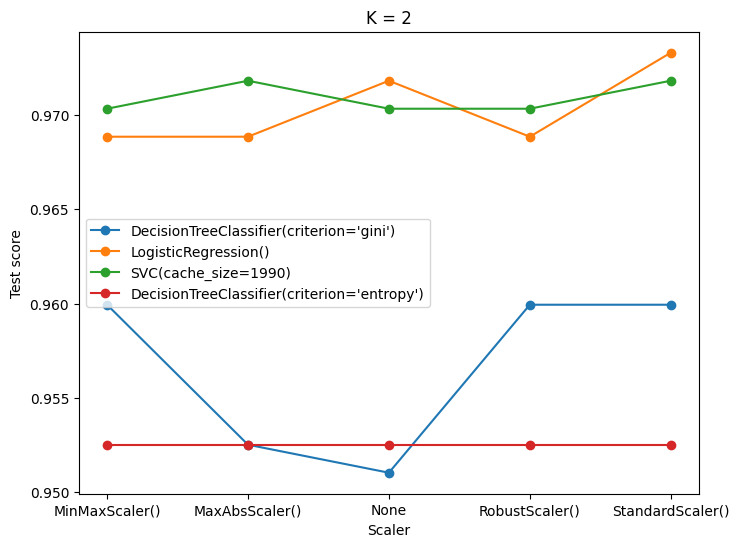

best : {'classifier': LogisticRegression(), 'classifier__C': 42.99985625343127, 'classifier__class_weight': None, 'classifier__dual': False, 'classifier__fit_intercept': False, 'classifier__intercept_scaling': 1.9000000000000001, 'classifier__max_iter': 400, 'classifier__penalty': 'none', 'classifier__random_state': 19970602, 'classifier__solver': 'saga', 'classifier__tol': 0.0053448338453303814, 'preprocessing': StandardScaler()}


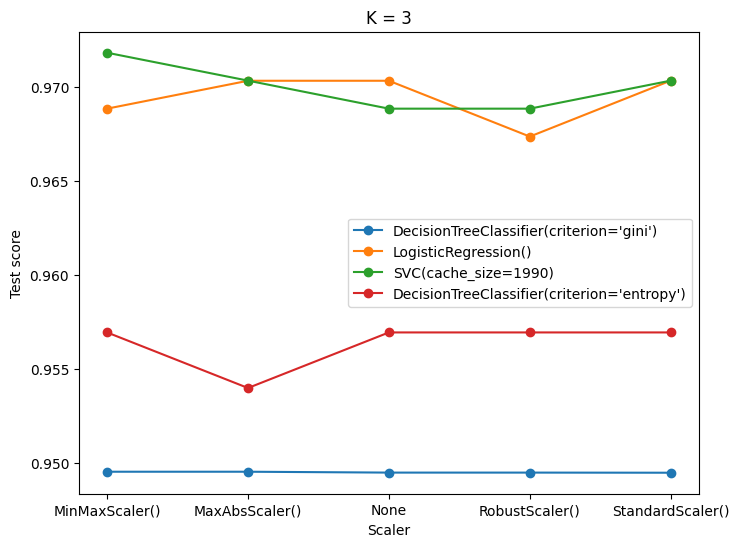

best : {'classifier': SVC(cache_size=1990), 'classifier__C': 0.19543774177714932, 'classifier__class_weight': 'balanced', 'classifier__coef0': 0.5, 'classifier__degree': 1, 'classifier__gamma': 9.999232501089905, 'classifier__kernel': 'linear', 'classifier__random_state': 19970602, 'classifier__shrinking': False, 'classifier__tol': 0.005862239917502197, 'preprocessing': MinMaxScaler()}


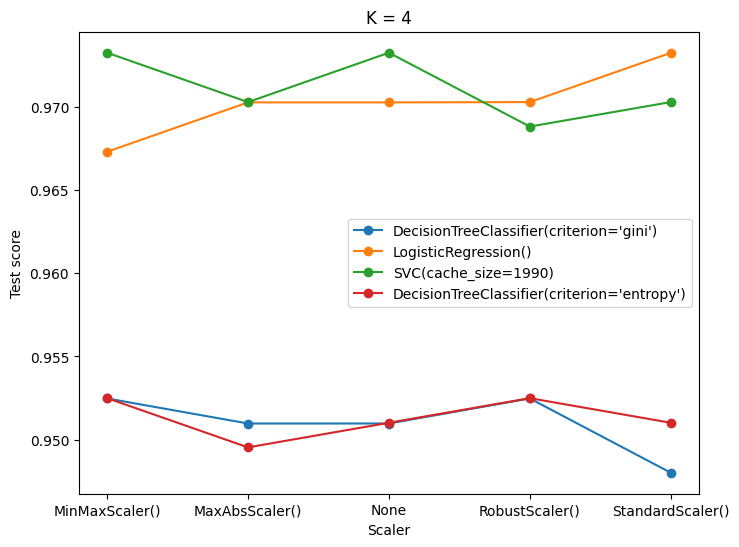

best : {'classifier': SVC(cache_size=1990), 'classifier__C': 0.01010900032573184, 'classifier__class_weight': 'balanced', 'classifier__coef0': 0.30000000000000004, 'classifier__degree': 4, 'classifier__gamma': 14.677241643721459, 'classifier__kernel': 'linear', 'classifier__random_state': 19970602, 'classifier__shrinking': True, 'classifier__tol': 0.005310112240476156, 'preprocessing': None}


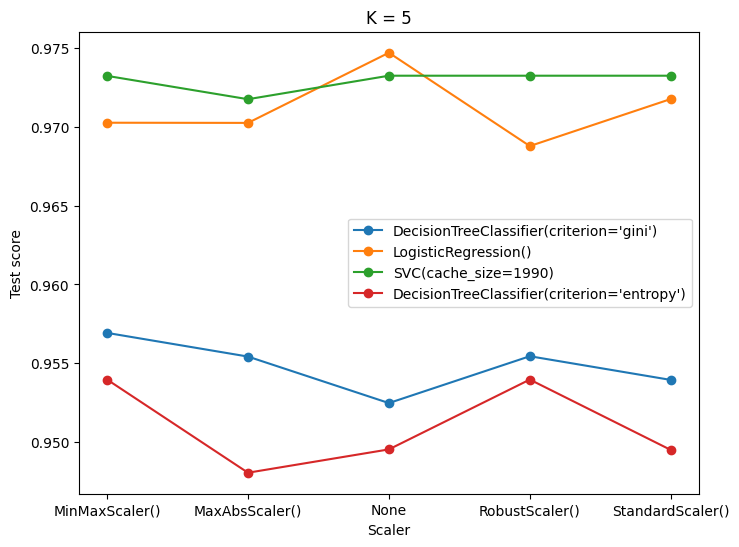

best : {'classifier': LogisticRegression(), 'classifier__C': 0.015906133477722854, 'classifier__class_weight': 'balanced', 'classifier__dual': False, 'classifier__fit_intercept': True, 'classifier__intercept_scaling': 0.6, 'classifier__max_iter': 300, 'classifier__penalty': 'none', 'classifier__random_state': 19970602, 'classifier__solver': 'saga', 'classifier__tol': 0.0005811987614662755, 'preprocessing': None}


In [34]:
# Visualize for each fold
for k in folds:
    plt.figure(figsize = (8, 6))
    plt.title(f'K = {k}')
    plt.xlabel('Scaler')
    plt.ylabel('Test score')
    classifierLabels = best[k].keys()

    for classifier in classifierLabels:
        scalerLabels = best[k][classifier].keys()
        scoreLabels = []

        for scaler in scalerLabels:
            scoreLabels.append(best[k][classifier][scaler]['mean_test_score'])

        plt.plot(scalerLabels, scoreLabels,
                 marker='o', lw=1.5,
                 label = classifier if classifier != 'DecisionTreeClassifier()' else "DecisionTreeClassifier(criterion='gini')")
        plt.legend(loc=0)

    plt.show()
    print(f'best : {best_params[k]}')